In [1]:
import re
import json
import datetime
import pandas as pd

import numpy as np
import rasterio as rio
import pandas as pd
import geopandas as gp
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

# Helper 
def sci_notation(num, decimal_digits=3, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times10^{{{1:d}}}$".format(coeff, exponent, precision)

In [2]:
# Read app db dump

measurements = []
for line in open("../data/pa/app/bq-results-20230823-141312-1692800006186.json", 'r'):
    measurements.append(json.loads(line))

# check for errors - if no indices print, proceed
for idx, x in enumerate(measurements):
    if measurements[idx]['__error__']: 
        print(idx)

# Extrat trees line by line
outrows = []

# Read only to the first 100 items, since the recent entries in the db are all we need
for idx,tree in enumerate(measurements[:70]):
    diam = measurements[idx]['diameter']['value']
    height = measurements[idx]['height']['value']
    unit = measurements[idx]['height']['unit']
    species = measurements[idx]['speciesName']
    date = measurements[idx]['captureDate']
    parcel = measurements[idx]['parcelId']
    lat = measurements[idx]['lat']
    lon = measurements[idx]['long']
    tree_id = measurements[idx]['id']

    if 'url' in measurements[idx]['photos'][0].keys():
        diam_url = measurements[idx]['photos'][0]['url']
        height_url = measurements[idx]['photos'][0]['url']
    else:
        diam_url = ""
        height_url = ""
    
    if "notes" in tree.keys():
        notes = measurements[idx]['notes']
    else:
        notes = ""
        
    treedf = pd.DataFrame([date,lat,lon,tree_id,diam,height,species,height_url, diam_url,parcel, notes]).T
    treedf.columns = ['date','lat','lon','tree_id','diam','height','species','height_url', 'diam_url','parcel_id','notes']
    outrows.append(treedf)

In [3]:
# Concat
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])

# select dates of trial
mask = (valdf['date'] > "2023-5-07") & (valdf['date'] <= '2023-05-09')
len(valdf[mask])

# Filter for dates
appdf = valdf[mask]

# filter for tims farm only 
appdf = appdf[appdf['parcel_id'] == "34EC3ED1-27D2-48AD-8BEC-6CB63260006D"]

# Split up the notes column  to row / col
notescol = list(appdf['notes'])

rows = []
cols = []

for x in notescol:
    xstr = x.lower()
    rows.append(xstr[:1])
    cols.append(xstr[1:])

# Apply indices  
appdf['row'] = rows
appdf['tree_idx'] = cols

appdf['row'] = appdf['row']#.astype(float)
appdf['tree_idx'] = appdf['tree_idx'].astype(float)
appdf['diam_app_cm'] = appdf['diam'].astype(float) * 2.54 # in to cm
appdf['height_app_cm'] = appdf['height'].astype(float) * 2.54 # in to cm 
appdf['lat'] = appdf['lat'].astype(float)
appdf['lon'] = appdf['lon'].astype(float)

# Sort by date 
appdf = appdf.sort_values(by='date', ascending = True)


In [4]:
mandf = pd.read_excel("../data/pa/manual/Tims_farm_manual.xlsx")

# changes types for the join
mandf['row_id']= mandf['row_id'].astype(str)
mandf['row_id'] = [x.lower()  for x in mandf['row_id']]
appdf['tree_id']=appdf['tree_id'].astype(str)
appdf['species']=appdf['species'].astype(str)
appdf['diam_url']=appdf['diam_url'].astype(str)

# merge, correct units 
new_df = pd.merge(mandf, appdf,  how='left', left_on=['row_id','col_id'], right_on = ['row','tree_idx'])
new_df['diam_tape'] = new_df['Circumference (in)'] / np.pi * 2.54
new_df['height_tape'] = new_df["height (yards)"] * 12 * 3 * 2.54

In [5]:
padf = new_df.drop(['Tree_id','row_id','col_id','Circumference (in)', 'height (yards)', 'Unnamed: 5',
                    'row','tree_idx','diam','height',
                   'date','lat','lon','tree_id','species','height_url','diam_url','parcel_id'], axis = 1)

In [6]:
padf.rename(columns = {"notes":"id"}, inplace = True)
padf['phone'] = 'iphone'
padf['User'] = 'Aakash'

In [7]:
# Read stanford field trial 
sdf = pd.read_csv("../data/stanford/combined.csv")

In [8]:
stdf = sdf.drop(["Height (inches)",'Diameter (inches)'],axis = 1)

In [9]:
# Combine
compdf = pd.concat([padf,stdf], axis =0)


Text(0, 0.5, 'app-based height (cm)')

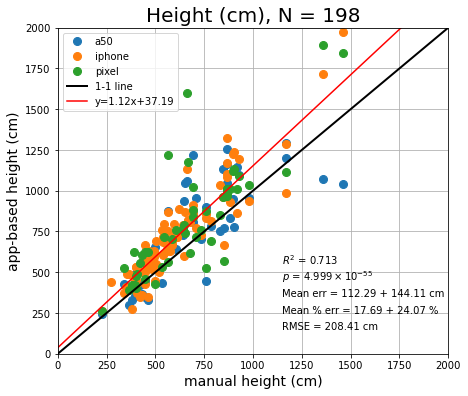

In [19]:
# Plot 
groups = compdf.groupby('phone')

# Plot
fig, ax = plt.subplots(figsize = (7,6))

# Scatterplot each tree
for name, group in groups:
    ax.plot(group['height_tape'], group['height_app_cm'], marker='o', linestyle='', ms=8, label=name)

    
# Plot 1-1 line
ax.plot([0,2000],[0,2000],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(compdf['height_tape'], compdf['height_app_cm'])

# Error Stats
mae = np.nanmean((compdf['height_app_cm'] - compdf['height_tape']))
mae_std = np.nanstd(abs(compdf['height_app_cm'] - compdf['height_tape']))
mape = np.nanmean(((compdf['height_app_cm'] - compdf['height_tape']) / compdf['height_tape'])) * 100
mape_std = np.nanstd(((compdf['height_app_cm'] - compdf['height_tape']) / compdf['height_tape'])) * 100
rmse = ((compdf['height_app_cm'] - compdf['height_tape']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,3000)+ intercept
plt.plot(np.linspace(0,3000), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [1150,550])
plt.annotate("$p$ = {}".format(sci_notation(p_value)), [1150,450])
plt.annotate("Mean err = {} + {} cm".format(str(round(mae,2)),str(round(mae_std,2))), [1150,350])
plt.annotate("Mean % err = {} + {} %".format(str(round(abs(mape),2)),str(round(mape_std,2))), [1150,250])
plt.annotate("RMSE = {} cm".format(str(round(rmse,2))), [1150,150])

ax.legend(loc = 'upper left')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)

titlestr = "Height (cm), N = {}".format(str(len(compdf)))
plt.title(titlestr, size = 20)
plt.grid()

plt.xlabel("manual height (cm)", size = 14)
plt.ylabel("app-based height (cm)", size = 14)

In [11]:
compdf.dtypes

id                object
diam_app_cm      float64
height_app_cm    float64
diam_tape        float64
height_tape      float64
phone             object
User              object
dtype: object

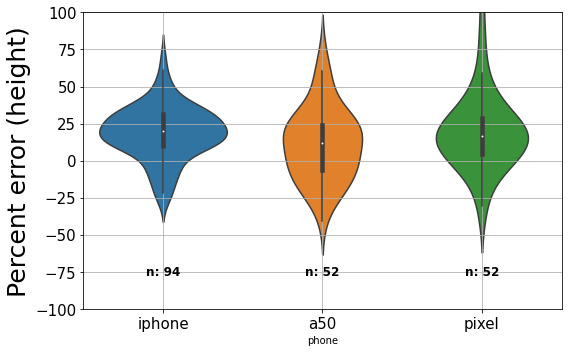

In [12]:
# error stats
compdf['mae'] = compdf['height_app_cm'] - compdf['height_tape']
compdf['mpe'] = (compdf['height_app_cm'] - compdf['height_tape']) / compdf['height_tape'] * 100
compdf['rmse'] = ((compdf['height_app_cm'] - compdf['height_tape']) ** 2).mean() ** .5

# violin plot of error 
plt.figure(figsize = (8,5))
ax = sns.violinplot(x="phone", y="mpe", data=compdf)
 
# Calculate number of obs per group & median to position labels
medians = compdf.groupby(['phone'])['mpe'].mean().values
nobs = compdf['phone'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
             -77.5,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='black',
            weight='semibold')
plt.ylabel("Percent error (height)", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.grid() 
plt.ylim([-100,100])

plt.tight_layout()

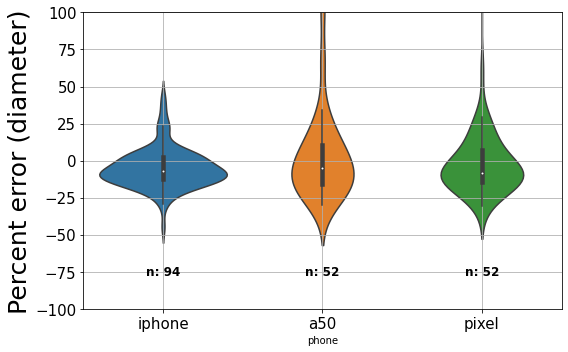

In [13]:
# error stats
compdf['mae_diam'] = compdf['diam_app_cm'] - compdf['diam_tape']
compdf['mpe_diam'] = (compdf['diam_app_cm'] - compdf['diam_tape']) / compdf['diam_tape'] * 100
compdf['rmse_diam'] = ((compdf['diam_app_cm'] - compdf['diam_tape']) ** 2).mean() ** .5

# violin plot of error 
plt.figure(figsize = (8,5))
ax = sns.violinplot(x="phone", y="mpe_diam", data=compdf)
 
# Calculate number of obs per group & median to position labels
medians = compdf.groupby(['phone'])['mpe_diam'].mean().values
nobs = compdf['phone'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
             -77.5,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='black',
            weight='semibold')
plt.ylabel("Percent error (diameter)", size = 25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.grid() 
plt.ylim([-100,100])

plt.tight_layout()

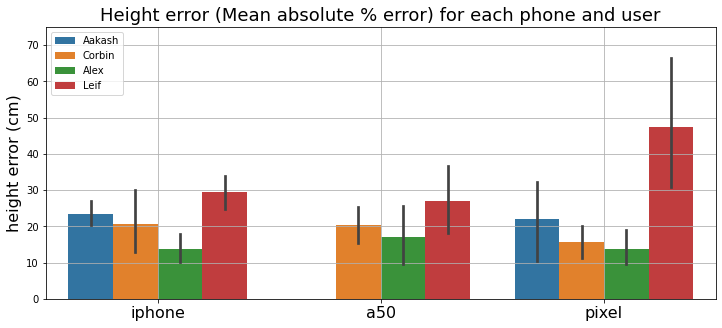

In [14]:
cdf = compdf.copy()

# Violin Plots 
cdf['mae'] = cdf['height_app_cm'] - cdf['height_tape']
cdf['mape'] = abs((cdf['height_app_cm'] - cdf['height_tape']) / cdf['height_tape'] * 100)
cdf['rmse'] = ((cdf['height_app_cm'] - cdf['height_tape']) ** 2).mean() ** .5

fig, ax = plt.subplots(figsize = (12,5))
ax = sns.barplot(x="phone", y="mape", hue="User", data=cdf)

medians = cdf.groupby(['phone','User'])['mape'].median()
nobs =  cdf.groupby(['phone','User']).apply(lambda x: 'n={}'.format(len(x)))

for ax in plt.gcf().axes:

    for tick, label in enumerate(ax.get_xticklabels()):
        ax_species = label.get_text()

        for j, ax_user in enumerate(ax.get_legend_handles_labels()[1]):
            try:
                x_offset = (j - (5-1)/2) * (5/((5*1)+1-1)) * 0.16
                med_val = medians[ax_user, ax_species] - 2.
                num = nobs[ax_user, ax_species]

                ax.text(tick + x_offset, med_val, num,
                        horizontalalignment='center', size='large', color='w', weight='semibold')
            except:
                continue

ax.tick_params(axis='x', labelsize=16)
plt.legend(title = None, loc = 'upper left')
plt.ylabel("height error (cm)", size = 16)
plt.xlabel("")
plt.title("Height error (Mean absolute % error) for each phone and user", size = 18)
plt.ylim([0,75])
plt.grid()
plt.show()

In [15]:
# remove users names
compdf.loc[compdf['User'] == 'Aakash', 'User'] = "User A"
compdf.loc[compdf['User'] == 'Leif', 'User'] = "User B"
compdf.loc[compdf['User'] == 'Corbin', 'User'] = "User C"
compdf.loc[compdf['User'] == 'Alex', 'User'] = "User D"

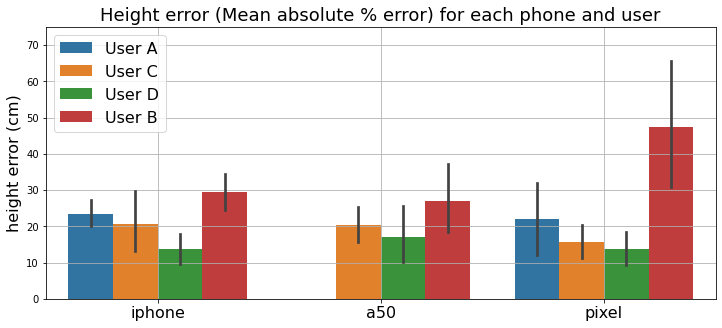

In [16]:
cdf = compdf.copy()

# Violin Plots 
cdf['mae'] = cdf['height_app_cm'] - cdf['height_tape']
cdf['mape'] = abs((cdf['height_app_cm'] - cdf['height_tape']) / cdf['height_tape'] * 100)
cdf['rmse'] = ((cdf['height_app_cm'] - cdf['height_tape']) ** 2).mean() ** .5

fig, ax = plt.subplots(figsize = (12,5))
ax = sns.barplot(x="phone", y="mape", hue="User", data=cdf)

medians = cdf.groupby(['phone','User'])['mape'].median()
nobs =  cdf.groupby(['phone','User']).apply(lambda x: 'n={}'.format(len(x)))

for ax in plt.gcf().axes:

    for tick, label in enumerate(ax.get_xticklabels()):
        ax_species = label.get_text()

        for j, ax_user in enumerate(ax.get_legend_handles_labels()[1]):
            try:
                x_offset = (j - (5-1)/2) * (5/((5*1)+1-1)) * 0.16
                med_val = medians[ax_user, ax_species] - 2.
                num = nobs[ax_user, ax_species]

                ax.text(tick + x_offset, med_val, num,
                        horizontalalignment='center', size='large', color='w', weight='semibold')
            except:
                continue

ax.tick_params(axis='x', labelsize=16)
plt.legend(title = None, loc = 'upper left', fontsize = 16)
plt.ylabel("height error (cm)", size = 16)
plt.xlabel("")
plt.title("Height error (Mean absolute % error) for each phone and user", size = 18)
plt.ylim([0,75])
plt.grid()
plt.show()